#### <b>DCGAN 실습</b>

* Deep Convolutional Generative Adversarial Networks <b>(ICLR 2016)</b>
* Convoluational Layer를 활용하여 이미지 생성에 높은 성능을 보이는 DCGAN 모델을 학습해 봅시다.
* 학습 데이터셋: <b>MNIST</b> (1 X 28 X 28)

#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

* CNN 연산을 위하여 이미지의 크기를 1 X 32 X 32 형태로 변경하여 사용합니다. (2의 거듭제곱수)

In [ ]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 8 # 원본 크기보다 4배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size * self.init_size)) # 초기 채널의 크기는 128 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 1로
            nn.Tanh(),
        )

    def forward(self, z):
        output = self.layer1(z)
        output = output.view(output.size(0), 128, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output

In [ ]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(1, 16, bn=False),
            *make_block(16, 32),
            *make_block(32, 64),
            *make_block(64, 128),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        output = self.conv_blocks(img)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>학습 데이터셋 불러오기</b>

* 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.694897] [G loss: 0.690864] [Elapsed time: 20.87s]
[Epoch 1/200] [D loss: 0.698747] [G loss: 0.685665] [Elapsed time: 41.91s]
[Epoch 2/200] [D loss: 0.654233] [G loss: 0.821698] [Elapsed time: 63.17s]
[Epoch 3/200] [D loss: 0.610936] [G loss: 0.705884] [Elapsed time: 84.94s]
[Epoch 4/200] [D loss: 0.671104] [G loss: 0.932624] [Elapsed time: 107.27s]
[Epoch 5/200] [D loss: 0.609094] [G loss: 0.923977] [Elapsed time: 129.13s]
[Epoch 6/200] [D loss: 0.599244] [G loss: 1.010253] [Elapsed time: 150.83s]
[Epoch 7/200] [D loss: 0.490334] [G loss: 0.888359] [Elapsed time: 172.66s]
[Epoch 8/200] [D loss: 0.608828] [G loss: 0.994761] [Elapsed time: 194.60s]
[Epoch 9/200] [D loss: 0.557712] [G loss: 0.993231] [Elapsed time: 216.46s]
[Epoch 10/200] [D loss: 0.589897] [G loss: 0.940161] [Elapsed time: 238.29s]
[Epoch 11/200] [D loss: 0.635128] [G loss: 0.602069] [Elapsed time: 260.14s]
[Epoch 12/200] [D loss: 0.677250] [G loss: 0.701887] [Elapsed time: 281.99s]
[Epoch 13/200

* 생성된 이미지 예시를 출력합니다.

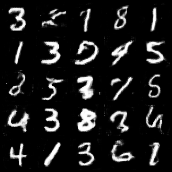

In [ ]:
from IPython.display import Image

Image('92000.png')